In [1]:
import arviz as az
import numpy as np  # For vectorized math operations

import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r
import seaborn as sns
from matplotlib import pyplot as plt

from IPython.display import display

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format='retina'

sns.set_theme(
    context="notebook",
    style="white",
    font="Latin Modern Roman",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "text.usetex": True,
    },
)

extra_params = {
    "text.latex.preamble": " ".join([r"\usepackage{mathtools}", r"\usepackage{amssymb}"])
}

plt.rcParams.update(extra_params)

# Estimation of Discrete Choice Models in PyMC

## Introduction

I'm encountering unexpected divergences in the estimation of Multinomial Logit Discrete Chocie Models. I first show how a model with only continuous regressors performs well. I then show how a model with a product fixed effect performs poorly. Here, poor performance meeans there are divergences.

In general, the data generating process is
$$
u_{ij} = \alpha_j + {X_j}'\beta + \eta_{ij} - \eta_0
$$
where:
- $\alpha_j$ is a consumer preference for brand $j$,
- $X_j$ is a matrix of product characteristics,
- $\beta$ is a vector of consumer utility parameters, and
- $\eta_{ij}$ are Gumbel-distributed errors.

In [3]:
def make_data(params):

    ## load parameters
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    product_features = np.random.normal(0, 1, (N, J, K))
    product_features = np.concatenate(
        [product_features, np.zeros((N, 1, K))], axis=1
    )  # outside good

    η = np.random.gumbel(0, 1, (N, J + 1))
    
    α_prod = np.random.normal(-1.0, 0.2, J+1)
    α_prod[-1] = 0 # outside good

    # β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
    β_prod = np.random.normal(0, 1, K)
    
    d = {
        "product_features": product_features,
        "latent_α": α_prod,
        "latent_β": β_prod,
    }

    ## generate data
    for k in ["model_1", "model_2"]:
        u = product_features @ β_prod + η
        if k == "model_2":
            u += np.ones((N, 1)) @ α_prod.reshape((1, -1))

        preferred_j = np.argmax(u, axis=1)
        inside_j    = np.argmax(u[:, :-1], axis=1)
    
        d[k] = {
            "u": u,
            "preferred_j": preferred_j,
            "inside_j": inside_j,
        }
    
    return d


params = {"N": 200, "J": 3, "K": 5}

data = make_data(params)

## Model 1: Continuous Charactersitics Only

Here, we are imposing that $\alpha_j = 0\;\forall j\in{}J$

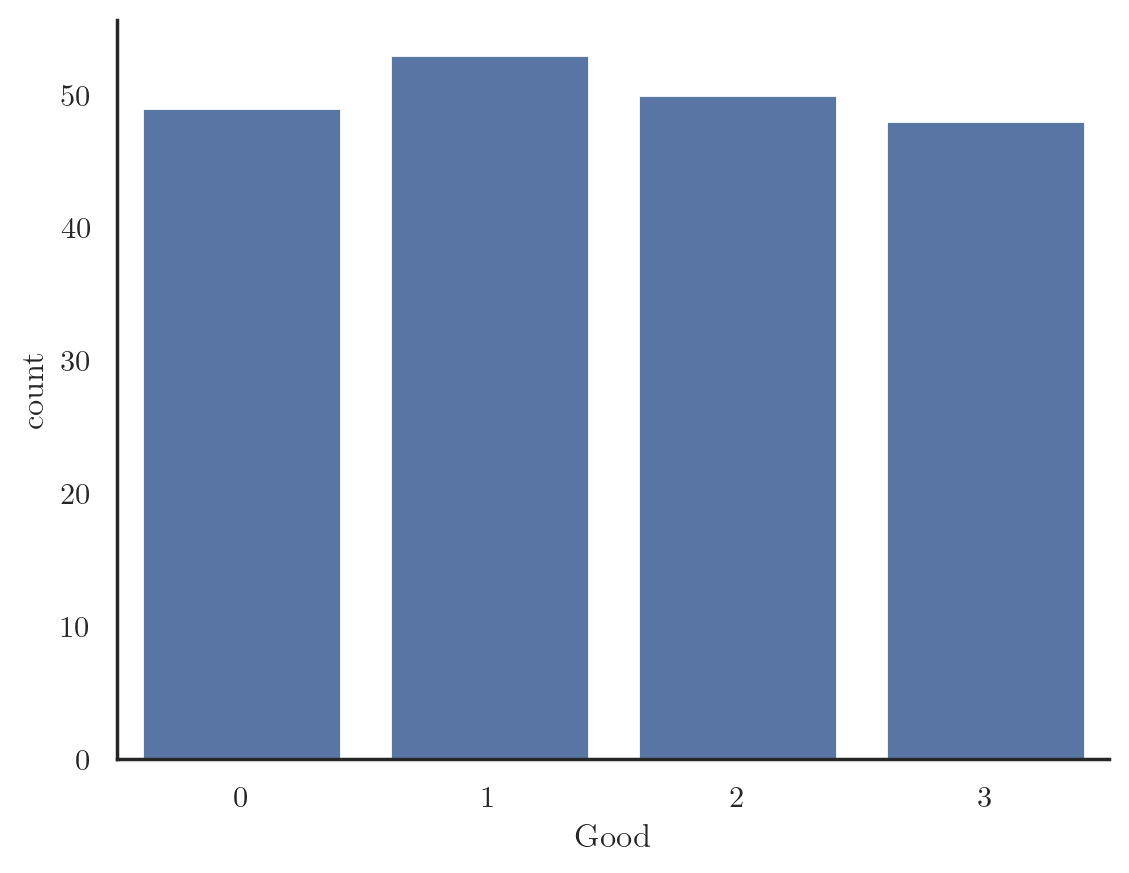

In [4]:
sns.countplot(
    x=pd.Series(data["model_1"]["preferred_j"], dtype="category", name="Good")
)
plt.show()

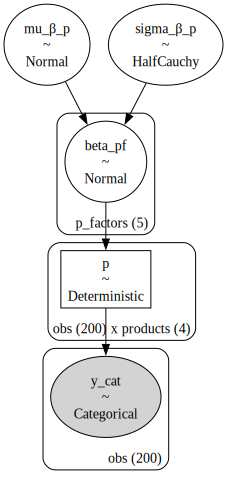

In [5]:
observed_good = data["model_1"]["preferred_j"]

N = params["N"]
J = params["J"]
K = params["K"]

coords_1 = {
    "products": [f"product_{i}" for i in range(J + 1)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

with pm.Model(coords=coords_1) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.HalfCauchy("sigma_β_p", 1)

    beta_p = pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"])

    ## Construct Utility matrix

    # beta_p_print = Print("beta_p")(beta_p)

    s = data["product_features"] @ beta_p

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

pm.model_to_graphviz(model_1)

In [6]:
with model_1:
    idata_m1 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [7]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    # no issues
    display(az.summary(idata_m1).loc[lambda _df: _df['ess_tail'] < 1_000])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [8]:
az.summary(idata_m1, var_names=["beta_pf"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],-0.272,0.105,-0.475,-0.083,0.001,0.001,24408.0,14423.0,1.0
beta_pf[pf_1],0.218,0.097,0.039,0.402,0.001,0.000,21805.0,15148.0,1.0
beta_pf[pf_2],-0.294,0.105,-0.491,-0.098,0.001,0.001,25149.0,13992.0,1.0
beta_pf[pf_3],0.344,0.107,0.138,0.539,0.001,0.001,21723.0,16055.0,1.0
beta_pf[pf_4],-0.436,0.106,-0.639,-0.240,0.001,0.001,21968.0,15031.0,1.0


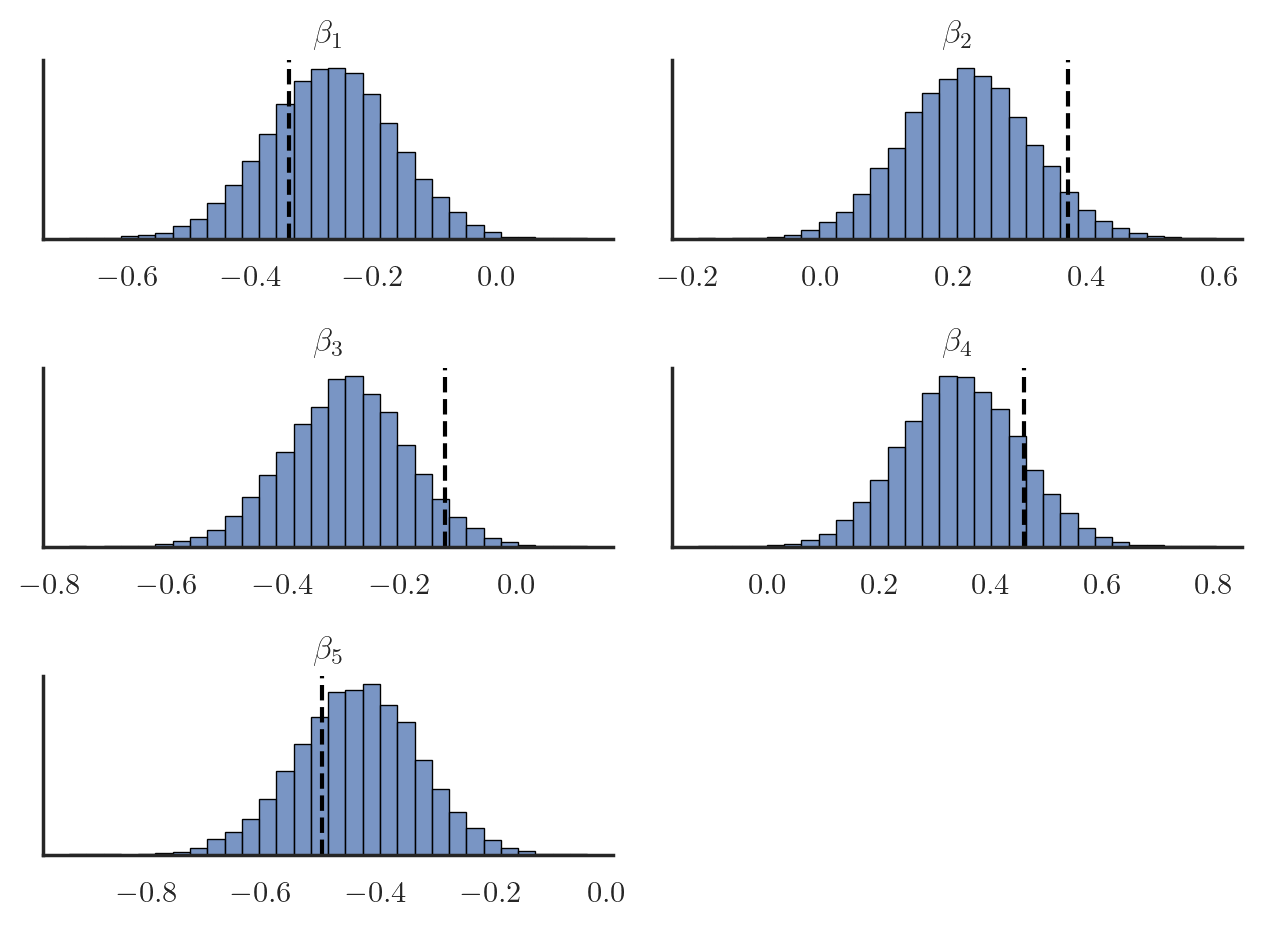

In [9]:
post = az.extract(idata_m1)

fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(data["latent_β"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

## Model 2: With Brand Fixed Effects

Here, we no longer impose that $\alpha_j = 0\;\forall j\in{}J$

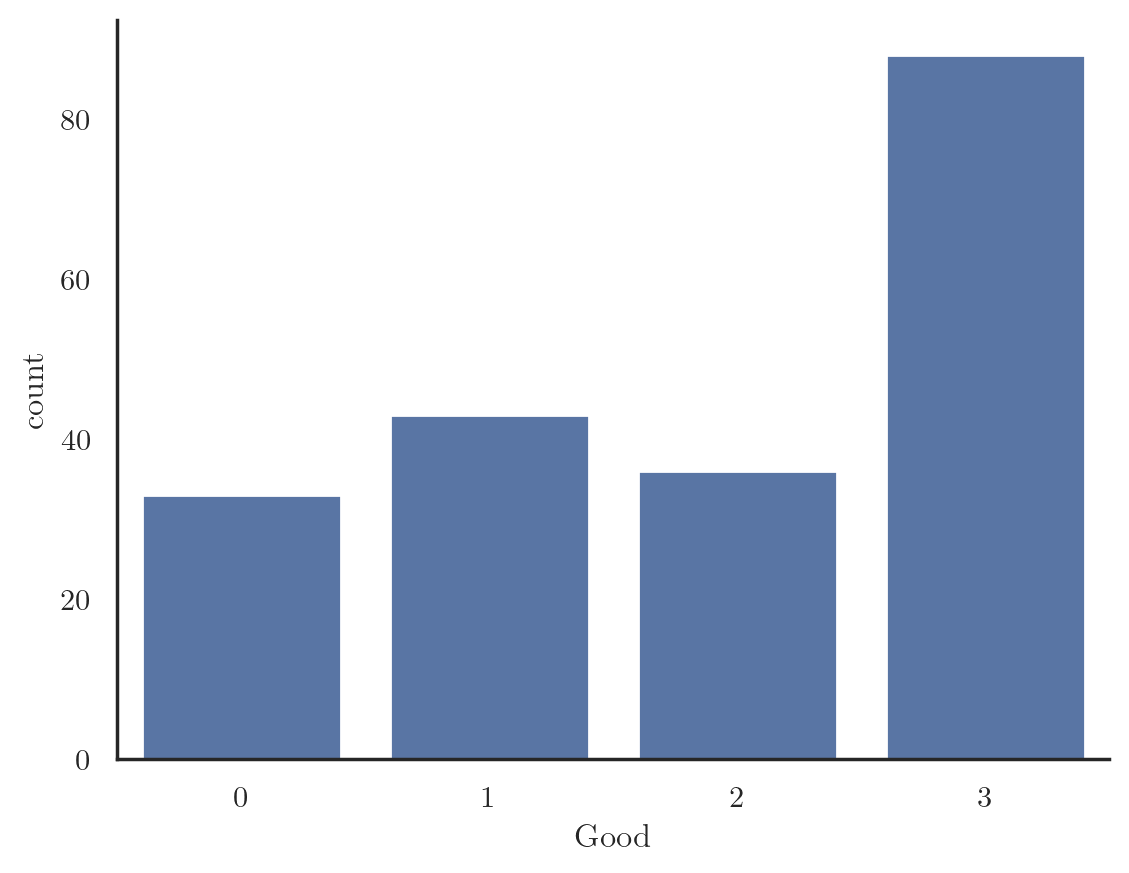

In [10]:
sns.countplot(
    x=pd.Series(data["model_2"]["preferred_j"], dtype="category", name="Good")
)
plt.show()

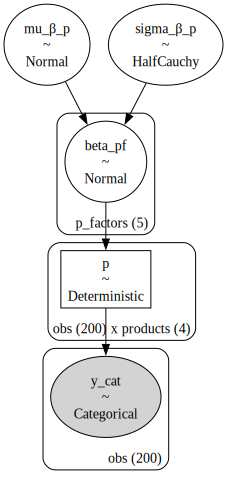

In [11]:
observed_good = data["model_2"]["preferred_j"]

N = params["N"]
J = params["J"]
K = params["K"]

coords_1 = {
    "products": [f"product_{i}" for i in range(J + 1)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

with pm.Model(coords=coords_1) as model_2:

    mu_α_p = pm.Normal("mu_α_p", 0, 1)
    sigma_α_p = pm.HalfCauchy("sigma_α_p", 1)

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.HalfCauchy("sigma_β_p", 1)

    alpha_p = pm.Normal("alpha_j", 0, 5, dims=["products"])
    alpha_p = pt.set_subtensor(alpha_p[-1], 0) #outside good

    beta_p = pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"])

    ## Construct Utility matrix

    # beta_p_print = Print("beta_p")(beta_p)

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + data["product_features"] @ beta_p

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

pm.model_to_graphviz(model_1)

In [12]:
with model_2:
    idata_m2 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [13]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    # no issues
    display(az.summary(idata_m2, var_names=["~p"]).loc[lambda _df: _df['ess_tail'] < 1_000])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [14]:
az.summary(idata_m2, var_names=["beta_pf"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],-0.289,0.112,-0.504,-0.082,0.001,0.001,21799.0,16128.0,1.0
beta_pf[pf_1],0.169,0.106,-0.033,0.366,0.001,0.001,22389.0,15222.0,1.0
beta_pf[pf_2],-0.244,0.115,-0.467,-0.036,0.001,0.001,20954.0,14672.0,1.0
beta_pf[pf_3],0.361,0.120,0.144,0.591,0.001,0.001,17443.0,16062.0,1.0
beta_pf[pf_4],-0.416,0.114,-0.640,-0.212,0.001,0.001,20927.0,15671.0,1.0


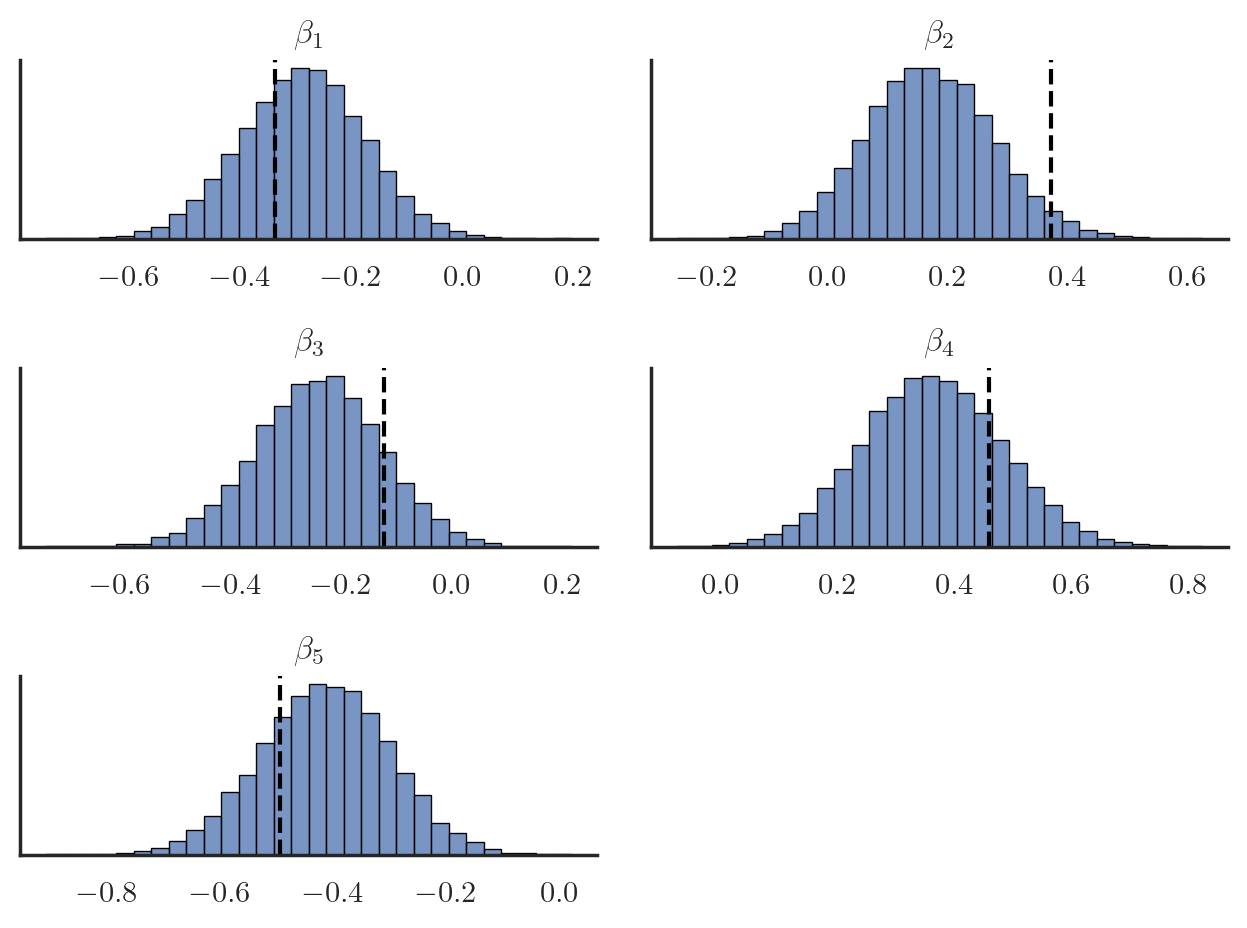

In [15]:
post = az.extract(idata_m2)

fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(data["latent_β"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()